# Definición del Problema

La salud mental es probablemente uno de los elementos más importantes para el ser humano; sin embargo, no se le brinda el cuidado adecuado, lo que lleva a que cualquier persona con una enfermedad mental no sea atendida, lo que deteriora completamente a la persona, inclusive en casos que la llevan a atentar contra su propia vida. Es por ello que, como equipo, consideramos que es importante ser capaces de detectar a aquellas personas que cuenten con una enfermedad mental haciendo uso de las redesneuronales.

## Descripción del Conjunto de Datos

Los datos obtenidos de Kaggel son el resultado de una encuesta sobre salud mental y condiciones de trabajo realizada en 2016 y aplicada a personas que en ese momento se encontraban trabajando en el area de la tecnologia. Dentro del mismo cuestionario se encuentra la pregunta "¿Haz sido diagnosticado con una enfermedad mental?" la cual será nuestra variable objetivo. 

# Dependencias

In [138]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from varclushi import VarClusHi
pd.options.mode.copy_on_write = True
pd.set_option('future.no_silent_downcasting', True)

In [99]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [100]:
from mpl_toolkits.mplot3d import Axes3D

In [101]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

# Carga de Datos

In [2]:
X = pd.read_csv('./data/mental-heath-in-tech-2016_20161114.csv')

In [3]:
X.shape

(1433, 63)

In [4]:
# Hay un error con el nombre de una pregunta que impide la comparación correcta.
X.columns.values[16] = 'Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?'

## Ausentes

Todas las columnas cuyo cantidad de ausentes era mayor a mil fueron eliminadas pues aportaban poca información y podrian causar ruido al modelo.

In [5]:
a = X.isna().sum().tolist()
names = []

In [6]:
for i, n in enumerate(a): 
    if a[i] > 1000:
        print(n, X.columns[i])
        names.append(X.columns[i])

1170 Is your primary role within your company related to tech/IT?
1146 Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?
1146 Do you know local or online resources to seek help for a mental health disorder?
1146 If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
1289 If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
1146 If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
1146 If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
1146 Do you believe your productivity is ever affected by a mental health issue?
1229 If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?

In [7]:
X = X.drop(names, axis=1)

In [8]:
X.shape

(1433, 53)

# Categorización de variables

In [9]:
pd.set_option('display.max_rows', 63)

In [10]:
X.nunique()

Are you self-employed?                                                                                                                                                                 2
How many employees does your company or organization have?                                                                                                                             6
Is your employer primarily a tech company/organization?                                                                                                                                2
Does your employer provide mental health benefits as part of healthcare coverage?                                                                                                      4
Do you know the options for mental health care available under your employer-provided coverage?                                                                                        3
Has your employer ever formally discussed mental health (for example, as pa

In [11]:
#Continuas
varc = ['Are you self-employed?',
        'Is your employer primarily a tech company/organization?',
        'What is your age?',
        'Do you have previous employers?',
       ]

#Discretas
vard = ['How many employees does your company or organization have?',
        'Does your employer provide mental health benefits as part of healthcare coverage?',
        'Do you know the options for mental health care available under your employer-provided coverage?',
        'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
        'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
        'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
        'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
        'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
        'Do you think that discussing a physical health issue with your employer would have negative consequences?',
        'Would you feel comfortable discussing a mental health disorder with your coworkers?',
        'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
        'Do you feel that your employer takes mental health as seriously as physical health?',
        'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
        'Have your previous employers provided mental health benefits?',
        'Were you aware of the options for mental health care provided by your previous employers?',
        'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
        'Did your previous employers provide resources to learn more about mental health issues and how to seek help?',
        'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?',
        'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',
        'Do you think that discussing a physical health issue with previous employers would have negative consequences?',
        'Did you feel that your previous employers took mental health as seriously as physical health?',
        'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?',
        'Would you be willing to bring up a physical health issue with a potential employer in an interview?',
        'Do you feel that being identified as a person with a mental health issue would hurt your career?',
        'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?', 
        'How willing would you be to share with friends and family that you have a mental illness?',
        'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?',
        'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?',
        'Do you have a family history of mental illness?',
        'Do you work remotely?',
        'Would you bring up a mental health issue with a potential employer in an interview?',
        ]

Como se explicó en la presentación del proyecto la variable objetivo es **'Have you been diagnosed with a mental health condition by a medical professional?'** sin embargo
existen preguntas dentro de la encuesta que responden indirectamente esto por lo que para evitar cesgos serán removidad de las variables.

In [12]:
cesgo = ['If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
         'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
         'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
         'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?',
         'Do you believe your productivity is ever affected by a mental health issue?',
         'Do you currently have a mental health disorder?',
         'If yes, what condition(s) have you been diagnosed with?',
         'If maybe, what condition(s) do you believe you have?',
         'Have you been diagnosed with a mental health condition by a medical professional?',
         'If so, what condition(s) were you diagnosed with?',
         'Have you ever sought treatment for a mental health issue from a mental health professional?',
         'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?', 
         'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?',
         'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
         'Have you had a mental health disorder in the past?',
         'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?',     
        ]

In [13]:
len(varc) + len(vard) + len(cesgo)

51

In [14]:
df = X[vard + varc]

In [15]:
df.head()

,How many employees does your company or organization have?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,...,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Do you have a family history of mental illness?,Do you work remotely?,Would you bring up a mental health issue with a potential employer in an interview?,Are you self-employed?,Is your employer primarily a tech company/organization?,What is your age?,Do you have previous employers?
0,26-100,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,...,Somewhat open,No,NaN,No,Sometimes,Maybe,0,1.0,39,1
1,6-25,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,...,Somewhat open,No,NaN,Yes,Never,No,0,1.0,29,1
2,6-25,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,...,Somewhat open,Maybe/Not sure,Yes,No,Always,Yes,0,1.0,38,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Neutral,No,NaN,No,Sometimes,Maybe,1,NaN,43,1
4,6-25,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,Maybe,Maybe,...,Somewhat open,"Yes, I experienced",Yes,Yes,Sometimes,No,0,0.0,43,1


# Análisis Exploratorio

## Discreto

Para las variables discretas rellenamos los ausentes, obtenemos las frecuencias para hacer uso de estas y realizar la normalización de variables.

In [18]:
for v in vard:
    df.fillna({v:'MISSING'}, inplace=True)

In [19]:
def freq(df, var):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame()
        aux.columns = ['FA']
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA', 'FRA']] = aux.apply(np.cumsum)
        print("Tabla de frecuentas para la variable **",v,"**\n\n")
        print(aux, "\n"*2)

In [20]:
freq(df,vard)

Tabla de frecuentas para la variable ** How many employees does your company or organization have? **


                                                     FA        FR   FAA  \
How many employees does your company or organiz...                        
26-100                                              292  0.203768   292   
MISSING                                             287  0.200279   579   
More than 1000                                      256  0.178646   835   
100-500                                             248  0.173064  1083   
6-25                                                210  0.146546  1293   
500-1000                                             80  0.055827  1373   
1-5                                                  60  0.041870  1433   

                                                         FRA  
How many employees does your company or organiz...            
26-100                                              0.203768  
MISSING                        

### Normalización

In [25]:
def normalizar(df, v, umbral=0.04):
    aux = df[v].value_counts(normalize=True).to_frame(v)
    aux['cat'] = np.where(aux[v]<umbral, 'OTROS', aux.index)
    moda = aux.head(1)['cat'].values[0]
    if aux.loc[aux['cat']=='OTROS'][v].sum()<umbral:
        aux.replace('cat', {'OTROS':moda},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    df[f'n_{v}'] = df[v].replace(aux.to_dict()['cat'])
    return df

In [26]:
for v in vard:
    df = normalizar(df,v)

In [27]:
varn = df.filter(like='n_').columns.tolist()

In [28]:
freq(df,varn)

Tabla de frecuentas para la variable ** n_How many employees does your company or organization have? **


                                                     FA        FR   FAA  \
n_How many employees does your company or organ...                        
26-100                                              292  0.203768   292   
MISSING                                             287  0.200279   579   
More than 1000                                      256  0.178646   835   
100-500                                             248  0.173064  1083   
6-25                                                210  0.146546  1293   
500-1000                                             80  0.055827  1373   
1-5                                                  60  0.041870  1433   

                                                         FRA  
n_How many employees does your company or organ...            
26-100                                              0.203768  
MISSING                      

### Quitar Unarios (Varianza 0)

In [29]:
unarias = [v for v,n in zip(varn, [df[v].unique().shape[0] for v in varn]) if n==1]
unarias

[]

## Continuo


### Nulos

In [33]:
df = df.fillna(0)

### Discretización

In [34]:
kb = KBinsDiscretizer(n_bins=5,encode='ordinal', strategy='quantile')

In [35]:
for v in varc:
    kb.fit(df[[v]])
    df[f'd_{v}'] = pd.cut(df[v], bins=kb.bin_edges_[0],include_lowest=True).astype(str)

/home/betaray/RN-2024-2/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/betaray/RN-2024-2/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/betaray/RN-2024-2/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [36]:
vari = [v for v in df.columns if v[:2] == 'd_']

In [37]:
freq(df, vari)

Tabla de frecuentas para la variable ** d_Are you self-employed? **


                            FA        FR   FAA       FRA
d_Are you self-employed?                                
(-0.001, 0.6]             1146  0.799721  1146  0.799721
(0.6, 1.0]                 287  0.200279  1433  1.000000 


Tabla de frecuentas para la variable ** d_Is your employer primarily a tech company/organization? **


                                                      FA   FR   FAA  FRA
d_Is your employer primarily a tech company/org...                      
(-0.001, 1.0]                                       1433  1.0  1433  1.0 


Tabla de frecuentas para la variable ** d_What is your age? **


                      FA        FR   FAA       FRA
d_What is your age?                               
(27.0, 31.0]         329  0.229588   329  0.229588
(2.999, 27.0]        297  0.207258   626  0.436846
(31.0, 35.0]         284  0.198186   910  0.635031
(40.0, 323.0]        269  0.187718  1179  0.822749
(35

# Variable Objetivo (Have you been diagnosed with a mental health condition by a medical professional?)

Observamos que para la variable objetivo la frecuencia son similares para ambos valores por lo que no es necesario hacer uso de tecnicas de muestro avanzadas.

In [41]:
freq(X, 'Have you been diagnosed with a mental health condition by a medical professional?')

Tabla de frecuentas para la variable ** Have you been diagnosed with a mental health condition by a medical professional? **


                                                     FA        FR   FAA  \
Have you been diagnosed with a mental health co...                        
No                                                  717  0.500349   717   
Yes                                                 716  0.499651  1433   

                                                         FRA  
Have you been diagnosed with a mental health co...            
No                                                  0.500349  
Yes                                                 1.000000   




In [44]:
df['y'] = (X['Have you been diagnosed with a mental health condition by a medical professional?'] == 'Yes').astype(int)

In [45]:
freq(df,'y')

Tabla de frecuentas para la variable ** y **


    FA        FR   FAA       FRA
y                               
0  717  0.500349   717  0.500349
1  716  0.499651  1433  1.000000 




# Transformación WoE

In [46]:
var = varn + vari
len(var)

35

In [47]:
def codificacion_woe(df,v,tgt):
    aux = df[[v,'y']].copy().assign(n=1)
    aux = aux.pivot_table(index=v, columns=tgt, values='n', aggfunc='sum')
    aux/=aux.apply(np.sum)
    aux['woe'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1, inplace=True)
    return v,aux.to_dict()['woe']

# Particion

In [48]:
X = df[var+['y']].copy()
X_train, X_test = train_test_split(X,train_size=0.7)

In [50]:
X_train.head(1)

,n_How many employees does your company or organization have?,n_Does your employer provide mental health benefits as part of healthcare coverage?,n_Do you know the options for mental health care available under your employer-provided coverage?,"n_Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",n_Does your employer offer resources to learn more about mental health concerns and options for seeking help?,n_Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"n_If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",n_Do you think that discussing a mental health disorder with your employer would have negative consequences?,n_Do you think that discussing a physical health issue with your employer would have negative consequences?,n_Would you feel comfortable discussing a mental health disorder with your coworkers?,...,n_Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,n_Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,n_Do you have a family history of mental illness?,n_Do you work remotely?,n_Would you bring up a mental health issue with a potential employer in an interview?,d_Are you self-employed?,d_Is your employer primarily a tech company/organization?,d_What is your age?,d_Do you have previous employers?,y
758,More than 1000,Yes,Yes,No,Yes,Yes,Somewhat easy,Maybe,No,No,...,"Yes, I experienced",MISSING,Yes,Never,No,"(-0.001, 0.6]","(-0.001, 1.0]","(35.0, 40.0]","(-0.001, 1.0]",1


In [51]:
lista_woe = []
for v in var:
    lista_woe.append(codificacion_woe(X_train, v, 'y'))

In [54]:
for v,dw in lista_woe:
    X_train[f'w_{v}'] = X_train[v].replace(dw)
    X_test[f'w_{v}'] = X_test[v].replace(dw)

In [57]:
varw = [v for v in X_train.columns if v[:2] == 'w_']
len(varw)

35

freq(X_train, varw)

# Medición de IV

In [62]:
def calcular_iv(df,v,tgt):
    aux = df[[v,'y']].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum')
    aux/=aux.apply(np.sum)
    aux['woe'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['woe']
    return v,aux['iv'].sum()

In [63]:
iv = []
for v in var:
    iv.append(calcular_iv(X_test, v, 'y'))

In [65]:
iv = pd.DataFrame(iv, columns=['variable', 'iv'])

In [67]:
best = iv.sort_values(by='iv', ascending=False).head(6)['variable'].tolist()

In [68]:
best

['n_How willing would you be to share with friends and family that you have a mental illness?',
 'n_Do you have a family history of mental illness?',
 'n_Do you know the options for mental health care available under your employer-provided coverage?',
 'n_Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?',
 'n_Have your previous employers provided mental health benefits?',
 'n_Do you feel that being identified as a person with a mental health issue would hurt your career?']

In [69]:
varw = ['w_'+v for v in best]
varw

['w_n_How willing would you be to share with friends and family that you have a mental illness?',
 'w_n_Do you have a family history of mental illness?',
 'w_n_Do you know the options for mental health care available under your employer-provided coverage?',
 'w_n_Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?',
 'w_n_Have your previous employers provided mental health benefits?',
 'w_n_Do you feel that being identified as a person with a mental health issue would hurt your career?']

# Modelo

Dado que tenemos una variable objetivo el modelo debe de ser de aprendizaje supervisado y clasificación. Dentro de los modelos que cumplen lo anterior nuestra elección fue un Perceptron Multicapa pues fue aquel con el que más experiencias contabamos y del cual creímos obtendriamos mejores resultados.

In [140]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=10000, random_state=42)

## Entrenamiento

In [141]:
mlp.fit(X_train[varw], X_train['y'])

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10000, random_state=42)

In [143]:
print(roc_auc_score(y_true=X_train['y'], y_score= mlp.predict_proba(X_train[varw])[:, 1]))
print(roc_auc_score(y_true=X_test['y'], y_score= mlp.predict_proba(X_test[varw])[:, 1]))

0.8174190367118408
0.7994544155534868


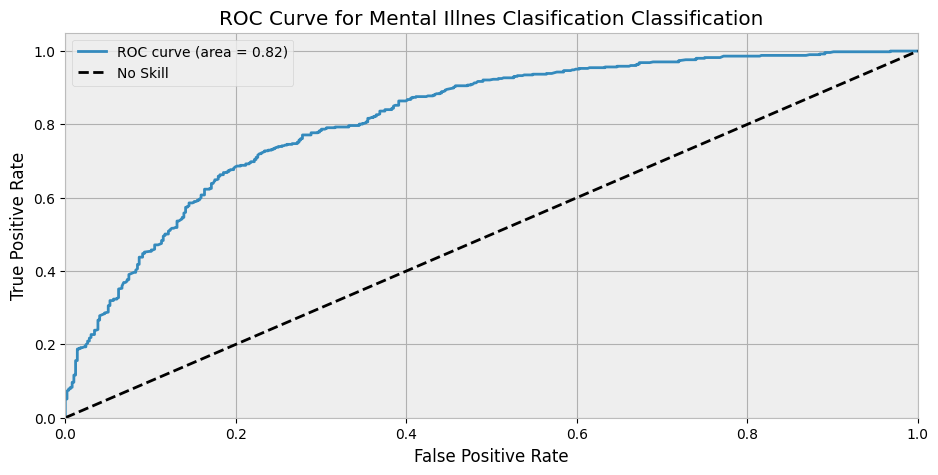

In [145]:
fpr, tpr, thresholds = roc_curve(X_train['y'],  mlp.predict_proba(X_train[varw])[:, 1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Mental Illnes Clasification Classification')
plt.legend()
plt.show()


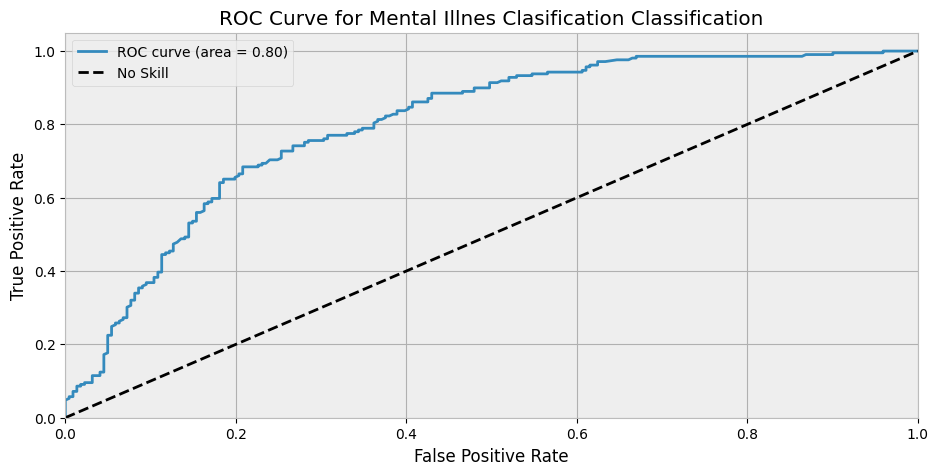

In [146]:
fpr, tpr, thresholds = roc_curve(X_test['y'],  mlp.predict_proba(X_test[varw])[:, 1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Mental Illnes Clasification Classification')
plt.legend()
plt.show()

In [124]:
# Evaluar el modelo
print('Accuracy:', accuracy_score(X_test['y'], y_pred))
print('Precision:', precision_score(X_test['y'], y_pred))
print('Recall:', recall_score(X_test['y'], y_pred))
print('F1 Score:', f1_score(X_test['y'], y_pred))

Accuracy: 0.7186046511627907
Precision: 0.688034188034188
Recall: 0.7703349282296651
F1 Score: 0.7268623024830699


In [127]:
print('Classification Report:\n', classification_report(X_test['y'], y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71       221
           1       0.69      0.77      0.73       209

    accuracy                           0.72       430
   macro avg       0.72      0.72      0.72       430
weighted avg       0.72      0.72      0.72       430

